# MaxSold Bid History Analysis

Analysis of bidding patterns and auction dynamics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime, timedelta

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
sns.set_palette('husl')

## Load Data

In [2]:
# Load the parquet file
data_path = Path('/workspaces/maxsold/data/bid_history/bid_history_20251201.parquet')
df = pd.read_parquet(data_path)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Dataset shape: (2107247, 6)

Columns: ['auction_id', 'item_id', 'bid_number', 'time_of_bid', 'amount', 'isproxy']

Memory usage: 276.63 MB


## Data Overview

In [3]:
# Display first few rows
df.head(10)

,auction_id,item_id,bid_number,time_of_bid,amount,isproxy
0,103882,7490316,1,2025-11-30 15:37:18-05:00,6.11,False
1,103882,7490316,2,2025-11-30 12:52:42-05:00,5.11,False
2,103882,7490316,3,2025-11-30 12:52:42-05:00,5.00,True
3,103882,7490316,4,2025-11-29 22:20:15-05:00,4.00,False
4,103882,7490316,5,2025-11-29 16:00:38-05:00,3.00,False
5,103882,7490316,6,2025-11-28 01:08:24-05:00,2.00,False
6,103882,7490316,7,2025-11-24 18:39:21-05:00,1.00,False
7,103882,7490302,1,2025-11-30 20:28:39-05:00,47.00,False
8,103882,7490302,2,2025-11-30 20:28:39-05:00,45.00,True
9,103882,7490302,3,2025-11-30 20:27:31-05:00,42.00,True


In [4]:
# Data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2107247 entries, 0 to 2107246
Data columns (total 6 columns):
 #   Column       Dtype                                 
---  ------       -----                                 
 0   auction_id   object                                
 1   item_id      object                                
 2   bid_number   Int64                                 
 3   time_of_bid  datetime64[us, pytz.FixedOffset(-300)]
 4   amount       float64                               
 5   isproxy      boolean                               
dtypes: Int64(1), boolean(1), datetime64[us, pytz.FixedOffset(-300)](1), float64(1), object(2)
memory usage: 86.4+ MB


In [5]:
# Check for missing values
missing_data = df.isnull().sum()
missing_pct = (missing_data / len(df)) * 100
missing_summary = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing %': missing_pct
}).sort_values('Missing Count', ascending=False)

print("=== Missing Values ===")
print(missing_summary[missing_summary['Missing Count'] > 0])

=== Missing Values ===
Empty DataFrame
Columns: [Missing Count, Missing %]
Index: []


In [6]:
# Summary statistics
df.describe()

,bid_number,amount
count,2107247.00,2107247.00
mean,10.20,38.10
std,10.57,155.38
min,1.00,1.00
25%,3.00,4.00
50%,7.00,9.00
75%,13.00,27.00
max,157.00,14000.00


## Bid Analysis

In [7]:
# Find bid amount columns
bid_cols = [col for col in df.columns if 'bid' in col.lower() or 'amount' in col.lower() or 'price' in col.lower()]
print(f"Bid-related columns: {bid_cols}")

# Find timestamp columns
time_cols = [col for col in df.columns if 'time' in col.lower() or 'date' in col.lower()]
print(f"Time-related columns: {time_cols}")

# Find item/auction identifier columns
id_cols = [col for col in df.columns if 'id' in col.lower() or 'item' in col.lower() or 'auction' in col.lower()]
print(f"Identifier columns: {id_cols}")

# Find bidder columns
bidder_cols = [col for col in df.columns if 'bidder' in col.lower() or 'user' in col.lower()]
print(f"Bidder columns: {bidder_cols}")

Bid-related columns: ['bid_number', 'time_of_bid', 'amount']
Time-related columns: ['time_of_bid']
Identifier columns: ['auction_id', 'item_id', 'bid_number', 'time_of_bid']
Bidder columns: []


In [8]:
# Basic bid statistics
if bid_cols:
    for col in bid_cols:
        if df[col].dtype in ['int64', 'float64']:
            print(f"\n=== {col} Statistics ===")
            print(f"Total bids: {df[col].notna().sum():,}")
            print(f"Mean: ${df[col].mean():,.2f}")
            print(f"Median: ${df[col].median():,.2f}")
            print(f"Min: ${df[col].min():,.2f}")
            print(f"Max: ${df[col].max():,.2f}")
            print(f"Std Dev: ${df[col].std():,.2f}")


=== amount Statistics ===
Total bids: 2,107,247
Mean: $38.10
Median: $9.00
Min: $1.00
Max: $14,000.00
Std Dev: $155.38


## Bid Distribution Analysis

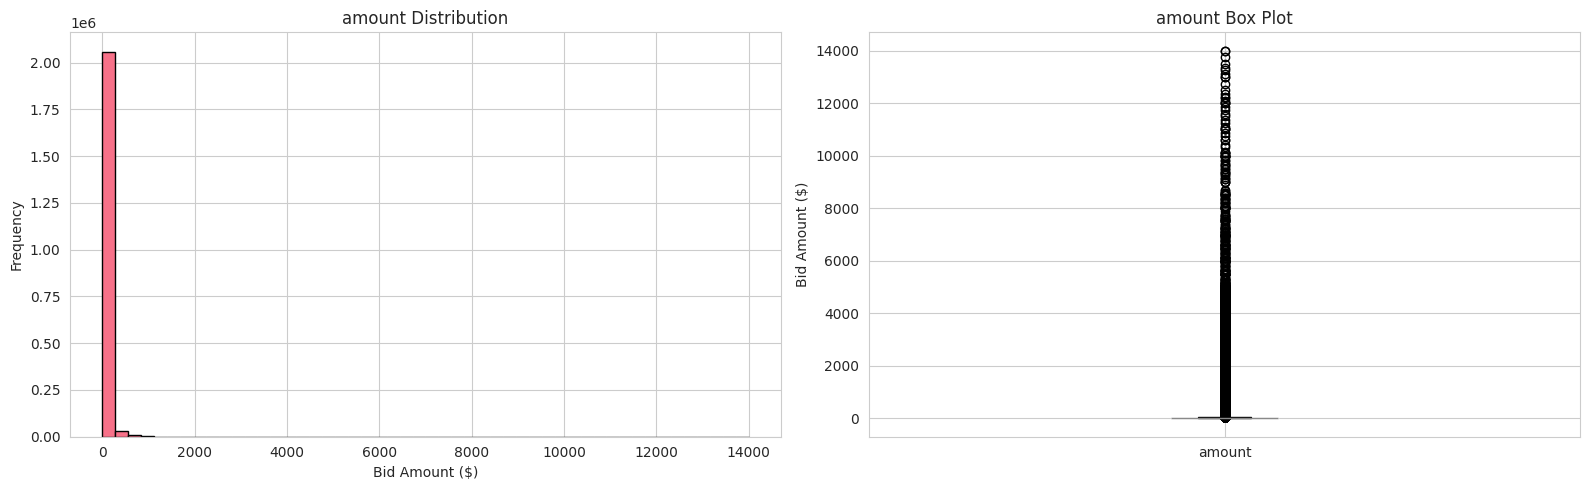

In [9]:
# Plot bid amount distribution
if bid_cols:
    n_plots = min(3, len([col for col in bid_cols if df[col].dtype in ['int64', 'float64']]))
    
    if n_plots > 0:
        fig, axes = plt.subplots(n_plots, 2, figsize=(16, 5*n_plots))
        if n_plots == 1:
            axes = axes.reshape(1, -1)
        
        plot_idx = 0
        for col in bid_cols:
            if df[col].dtype in ['int64', 'float64'] and plot_idx < n_plots:
                # Histogram
                df[col].hist(bins=50, ax=axes[plot_idx, 0], edgecolor='black')
                axes[plot_idx, 0].set_title(f'{col} Distribution')
                axes[plot_idx, 0].set_xlabel('Bid Amount ($)')
                axes[plot_idx, 0].set_ylabel('Frequency')
                
                # Box plot
                df.boxplot(column=col, ax=axes[plot_idx, 1])
                axes[plot_idx, 1].set_title(f'{col} Box Plot')
                axes[plot_idx, 1].set_ylabel('Bid Amount ($)')
                
                plot_idx += 1
        
        plt.tight_layout()
        plt.show()

In [10]:
# Bid amount percentiles
if bid_cols:
    for col in bid_cols:
        if df[col].dtype in ['int64', 'float64']:
            print(f"\n=== {col} Percentiles ===")
            percentiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
            for p in percentiles:
                value = df[col].quantile(p)
                print(f"{int(p*100)}th percentile: ${value:,.2f}")


=== amount Percentiles ===
10th percentile: $1.05
25th percentile: $4.00
50th percentile: $9.00
75th percentile: $27.00
90th percentile: $72.01
95th percentile: $145.00
99th percentile: $500.00


## Item/Auction Analysis

In [11]:
# Analyze bids per item/auction
if id_cols:
    for id_col in id_cols[:2]:  # Analyze first 2 ID columns
        if id_col in df.columns:
            print(f"\n=== Bids per {id_col} ===")
            bids_per_item = df[id_col].value_counts()
            print(f"Total unique {id_col}s: {bids_per_item.count():,}")
            print(f"Avg bids per {id_col}: {bids_per_item.mean():.2f}")
            print(f"Median bids per {id_col}: {bids_per_item.median():.2f}")
            print(f"Max bids on single {id_col}: {bids_per_item.max():,}")
            print(f"\nTop 10 {id_col}s by bid count:")
            print(bids_per_item.head(10))


=== Bids per auction_id ===
Total unique auction_ids: 1,914
Avg bids per auction_id: 1100.96
Median bids per auction_id: 934.00
Max bids on single auction_id: 8,328

Top 10 auction_ids by bid count:
auction_id
102848    8328
102811    7544
102401    5899
100238    5418
99720     4959
98507     4907
100899    4890
99823     4696
101401    4638
99196     4435
Name: count, dtype: int64

=== Bids per item_id ===
Total unique item_ids: 210,303
Avg bids per item_id: 10.02
Median bids per item_id: 8.00
Max bids on single item_id: 157

Top 10 item_ids by bid count:
item_id
7208367    157
7405626    145
7405622    144
7405629    143
7164454    142
7008880    142
7230764    140
7286374    137
7039549    136
7442660    134
Name: count, dtype: int64


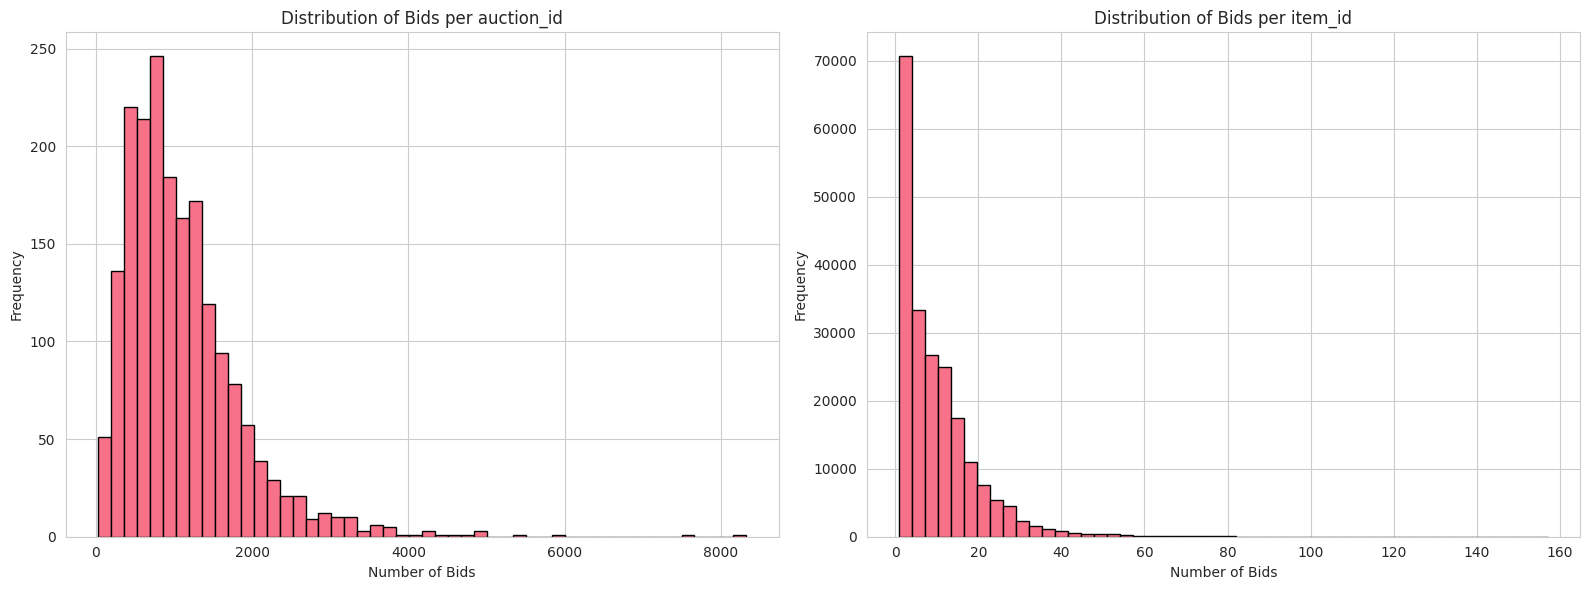

In [12]:
# Plot distribution of bids per item
if id_cols:
    fig, axes = plt.subplots(1, min(2, len(id_cols)), figsize=(16, 6))
    if len(id_cols) == 1:
        axes = [axes]
    
    for idx, id_col in enumerate(id_cols[:2]):
        if id_col in df.columns:
            bids_per_item = df[id_col].value_counts()
            bids_per_item.hist(bins=50, ax=axes[idx], edgecolor='black')
            axes[idx].set_title(f'Distribution of Bids per {id_col}')
            axes[idx].set_xlabel('Number of Bids')
            axes[idx].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

## Bidder Analysis

In [13]:
# Analyze bidder activity
if bidder_cols:
    for bidder_col in bidder_cols:
        if bidder_col in df.columns:
            print(f"\n=== {bidder_col} Activity ===")
            bidder_activity = df[bidder_col].value_counts()
            print(f"Total unique bidders: {bidder_activity.count():,}")
            print(f"Avg bids per bidder: {bidder_activity.mean():.2f}")
            print(f"Median bids per bidder: {bidder_activity.median():.2f}")
            print(f"Max bids by single bidder: {bidder_activity.max():,}")
            print(f"\nTop 10 most active bidders:")
            print(bidder_activity.head(10))

In [14]:
# Plot bidder activity distribution
if bidder_cols:
    for bidder_col in bidder_cols[:1]:  # Plot first bidder column
        if bidder_col in df.columns:
            bidder_activity = df[bidder_col].value_counts()
            
            fig, axes = plt.subplots(1, 2, figsize=(16, 6))
            
            # Histogram
            bidder_activity.hist(bins=50, ax=axes[0], edgecolor='black')
            axes[0].set_title(f'Distribution of Bids per {bidder_col}')
            axes[0].set_xlabel('Number of Bids')
            axes[0].set_ylabel('Number of Bidders')
            
            # Top bidders bar chart
            bidder_activity.head(20).plot(kind='barh', ax=axes[1])
            axes[1].set_title(f'Top 20 Most Active Bidders')
            axes[1].set_xlabel('Number of Bids')
            axes[1].set_ylabel(bidder_col)
            axes[1].invert_yaxis()
            
            plt.tight_layout()
            plt.show()

## Temporal Analysis

In [15]:
# Convert time columns to datetime
if time_cols:
    for time_col in time_cols:
        if time_col in df.columns:
            try:
                df[f'{time_col}_dt'] = pd.to_datetime(df[time_col])
                print(f"Converted {time_col} to datetime")
                print(f"Date range: {df[f'{time_col}_dt'].min()} to {df[f'{time_col}_dt'].max()}")
            except Exception as e:
                print(f"Could not convert {time_col} to datetime: {e}")

Converted time_of_bid to datetime
Date range: 2021-10-15 16:05:23-05:00 to 2025-11-30 21:06:19-05:00


In [16]:
# Analyze bidding patterns by time
datetime_cols = [col for col in df.columns if col.endswith('_dt')]

if datetime_cols:
    time_col = datetime_cols[0]
    
    # Extract time components
    df['hour'] = df[time_col].dt.hour
    df['day_of_week'] = df[time_col].dt.day_name()
    df['date'] = df[time_col].dt.date
    
    print("=== Temporal Patterns ===")
    print(f"\nBids by hour of day:")
    print(df['hour'].value_counts().sort_index())
    
    print(f"\nBids by day of week:")
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    print(df['day_of_week'].value_counts().reindex(day_order))

=== Temporal Patterns ===

Bids by hour of day:
hour
0      23504
1      13898
2       8915
3       7078
4       8700
5      18941
6      33714
7      49725
8      67268
9      70011
10     64639
11     63873
12     63964
13     67489
14     78331
15     84221
16     99133
17    133852
18    273730
19    453872
20    216116
21     97986
22     66276
23     42011
Name: count, dtype: int64

Bids by day of week:
day_of_week
Monday       217607
Tuesday      273340
Wednesday    372500
Thursday     534834
Friday       292246
Saturday     175553
Sunday       241167
Name: count, dtype: int64


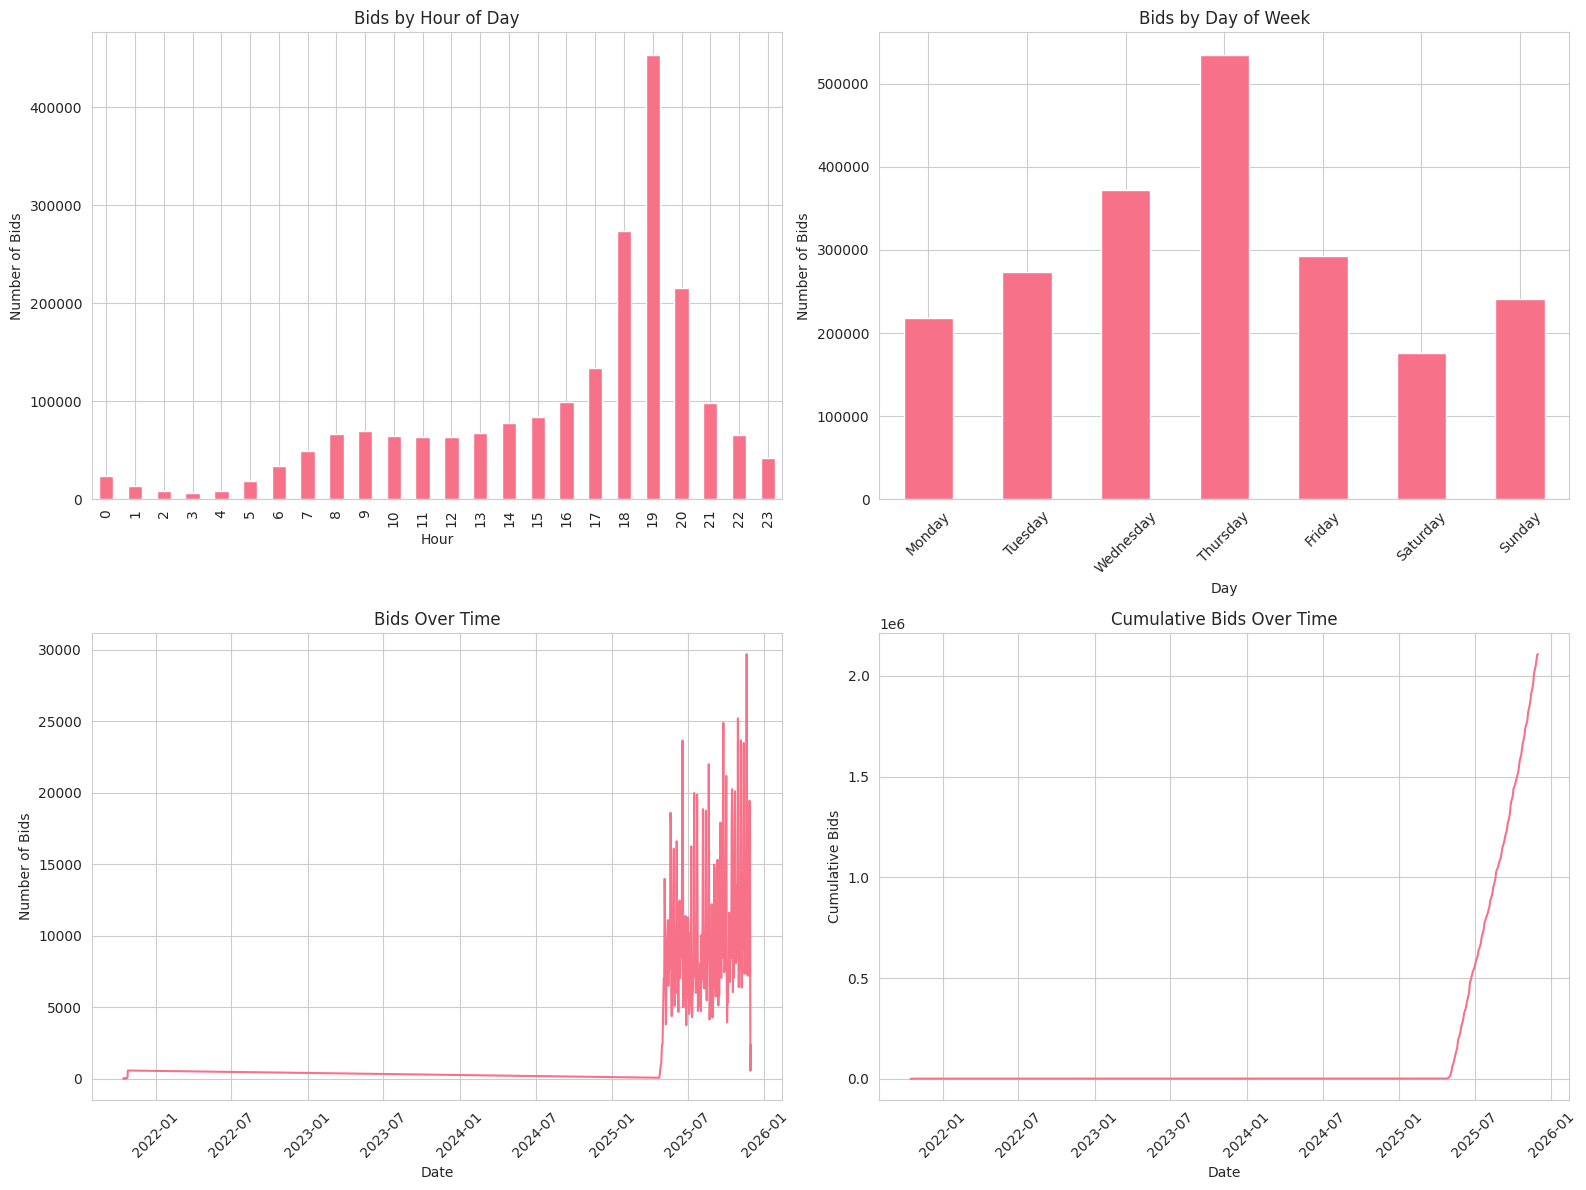

In [17]:
# Plot temporal patterns
if datetime_cols:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Bids by hour
    df['hour'].value_counts().sort_index().plot(kind='bar', ax=axes[0, 0])
    axes[0, 0].set_title('Bids by Hour of Day')
    axes[0, 0].set_xlabel('Hour')
    axes[0, 0].set_ylabel('Number of Bids')
    
    # Bids by day of week
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    df['day_of_week'].value_counts().reindex(day_order).plot(kind='bar', ax=axes[0, 1])
    axes[0, 1].set_title('Bids by Day of Week')
    axes[0, 1].set_xlabel('Day')
    axes[0, 1].set_ylabel('Number of Bids')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Bids over time
    df.groupby('date').size().plot(ax=axes[1, 0])
    axes[1, 0].set_title('Bids Over Time')
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].set_ylabel('Number of Bids')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Cumulative bids
    df.groupby('date').size().cumsum().plot(ax=axes[1, 1])
    axes[1, 1].set_title('Cumulative Bids Over Time')
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].set_ylabel('Cumulative Bids')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

## Competitive Bidding Analysis

In [20]:
# Analyze competitive items (items with multiple bids)
if id_cols and bid_cols:
    item_col = id_cols[0]
    bid_col = bid_cols[0] if bid_cols[0] in df.columns and df[bid_cols[0]].dtype in ['int64', 'float64'] else None
    
    if bid_col:
        # Group by item
        item_stats = df.groupby(item_col).agg({
            bid_col: ['count', 'min', 'max', 'mean', 'std'],
        }).round(2)
        
        item_stats.columns = ['_'.join(col).strip() for col in item_stats.columns.values]
        item_stats = item_stats.reset_index()
        
        # Calculate bid range
        item_stats['bid_range'] = item_stats[f'{bid_col}_max'] - item_stats[f'{bid_col}_min']
        
        print("=== Most Competitive Items (by number of bids) ===")
        print(item_stats.nlargest(10, f'{bid_col}_count'))
        
        print("\n=== Items with Highest Bid Range ===")
        print(item_stats.nlargest(10, 'bid_range'))

In [19]:
# Plot competitive bidding metrics
if id_cols and bid_cols:
    if bid_col and 'item_stats' in locals():
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Number of bids vs max bid
        axes[0, 0].scatter(item_stats[f'{bid_col}_count'], item_stats[f'{bid_col}_max'], alpha=0.5)
        axes[0, 0].set_title('Number of Bids vs Maximum Bid')
        axes[0, 0].set_xlabel('Number of Bids')
        axes[0, 0].set_ylabel('Maximum Bid ($)')
        
        # Number of bids vs bid range
        axes[0, 1].scatter(item_stats[f'{bid_col}_count'], item_stats['bid_range'], alpha=0.5)
        axes[0, 1].set_title('Number of Bids vs Bid Range')
        axes[0, 1].set_xlabel('Number of Bids')
        axes[0, 1].set_ylabel('Bid Range ($)')
        
        # Distribution of bid counts
        item_stats[f'{bid_col}_count'].hist(bins=50, ax=axes[1, 0], edgecolor='black')
        axes[1, 0].set_title('Distribution of Bid Counts per Item')
        axes[1, 0].set_xlabel('Number of Bids')
        axes[1, 0].set_ylabel('Number of Items')
        
        # Distribution of bid ranges
        item_stats['bid_range'].hist(bins=50, ax=axes[1, 1], edgecolor='black')
        axes[1, 1].set_title('Distribution of Bid Ranges')
        axes[1, 1].set_xlabel('Bid Range ($)')
        axes[1, 1].set_ylabel('Number of Items')
        
        plt.tight_layout()
        plt.show()

## Summary Report

In [21]:
# Generate comprehensive summary
summary = {
    'Total Bids': len(df),
}

if id_cols:
    summary['Unique Items'] = df[id_cols[0]].nunique()

if bidder_cols:
    summary['Unique Bidders'] = df[bidder_cols[0]].nunique()

if bid_cols:
    for col in bid_cols:
        if df[col].dtype in ['int64', 'float64']:
            summary[f'Avg {col}'] = f"${df[col].mean():,.2f}"
            summary[f'Median {col}'] = f"${df[col].median():,.2f}"
            summary[f'Total {col} Volume'] = f"${df[col].sum():,.2f}"
            break

if datetime_cols:
    summary['Date Range'] = f"{df[datetime_cols[0]].min()} to {df[datetime_cols[0]].max()}"
    summary['Duration (days)'] = (df[datetime_cols[0]].max() - df[datetime_cols[0]].min()).days

print("\n" + "="*50)
print("BID HISTORY SUMMARY REPORT")
print("="*50)
for key, value in summary.items():
    print(f"{key}: {value}")
print("="*50)


BID HISTORY SUMMARY REPORT
Total Bids: 2107247
Unique Items: 1914
Avg amount: $38.10
Median amount: $9.00
Total amount Volume: $80,291,011.93
Date Range: 2021-10-15 16:05:23-05:00 to 2025-11-30 21:06:19-05:00
Duration (days): 1507


## Custom Analysis

Add your custom analysis below:

In [ ]:
# Your custom analysis here


In [ ]:
# compute time since first bid for each itemdfdffdf
first_bid_per_item = df.groupby('item_id')[time_col].transform('min')
df['time_since_first_bid'] = df[time_col] - first_bid_per_item

# optional numeric column (seconds)
df['time_since_first_bid_seconds'] = df['time_since_first_bid'].dt.total_seconds()

# quick check
df[['item_id', time_col, 'time_since_first_bid', 'time_since_first_bid_seconds']].head()

In [22]:
first_bid_per_item = df.groupby('item_id')[time_col].transform('min')
df['time_since_first_bid'] = df[time_col] - first_bid_per_item

# optional numeric column (seconds)
df['time_since_first_bid_seconds'] = df['time_since_first_bid'].dt.total_seconds()

# quick check
df[['item_id', time_col, 'time_since_first_bid', 'time_since_first_bid_seconds']].head()

,item_id,time_of_bid_dt,time_since_first_bid,time_since_first_bid_seconds
0,7490316,2025-11-30 15:37:18-05:00,5 days 20:57:57,507477.00
1,7490316,2025-11-30 12:52:42-05:00,5 days 18:13:21,497601.00
2,7490316,2025-11-30 12:52:42-05:00,5 days 18:13:21,497601.00
3,7490316,2025-11-29 22:20:15-05:00,5 days 03:40:54,445254.00
4,7490316,2025-11-29 16:00:38-05:00,4 days 21:21:17,422477.00


In [ ]:
# Plot bid amount vs time since first bid (seconds)
x = df['time_since_first_bid_seconds']
y = df[col]  # 'amount'

# downsample for plotting if dataset is large
n = len(df)
if n > 250000:
    sample_frac = 250000 / n
    sample = df.sample(frac=sample_frac, random_state=42)
    x_plot = sample['time_since_first_bid_seconds'] + 1.0  # +1 to allow log scale
    y_plot = sample[col]
else:
    x_plot = x + 1.0
    y_plot = y

fig, ax = plt.subplots(figsize=(12, 6))

# use hexbin for dense scatter; color = log(count)
hb = ax.hexbin(x_plot, y_plot, gridsize=200, cmap='viridis', bins='log', mincnt=1)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log(count)')

ax.set_xscale('log')
ax.set_xlabel('Time since first bid (seconds, +1)')
ax.set_ylabel(col.capitalize())
ax.set_title('Bid amount vs Time since first bid (seconds)')

plt.show()

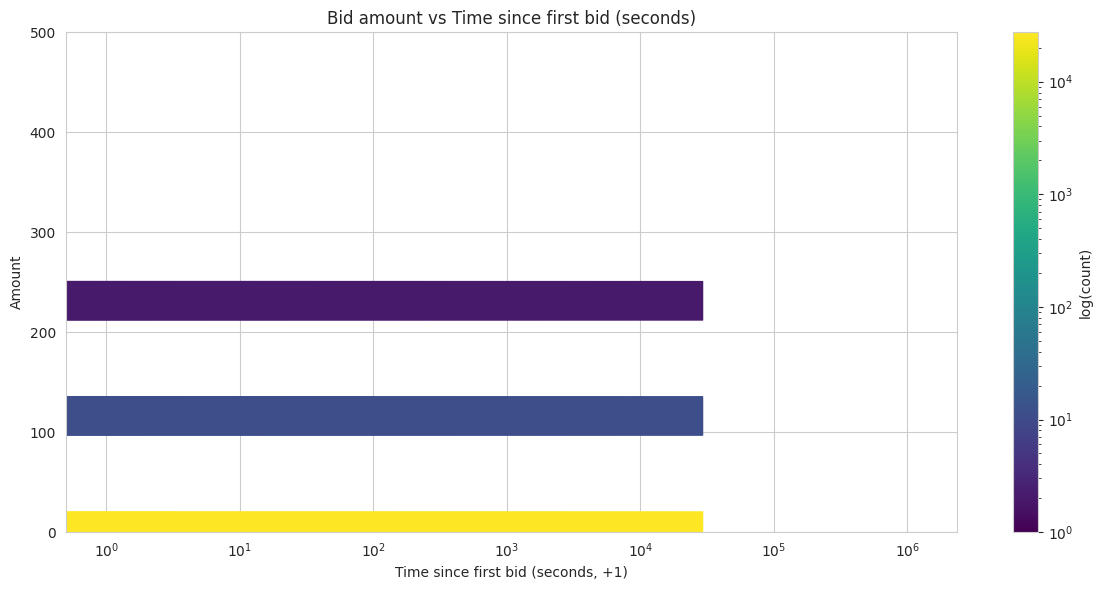

In [25]:
# Plot bid amount vs time since first bid (seconds)
x = df['time_since_first_bid_seconds']
y = df[col]  # 'amount'

# downsample for plotting if dataset is large
n = len(df)
if n > 250000:
    sample_frac = 250000 / n
    sample = df.sample(frac=sample_frac, random_state=42)
    x_plot = sample['time_since_first_bid_seconds'] + 1.0  # +1 to allow log scale
    y_plot = sample[col]
else:
    x_plot = x + 1.0
    y_plot = y

fig, ax = plt.subplots(figsize=(12, 6))

# use hexbin for dense scatter; color = log(count)
hb = ax.hexbin(x_plot, y_plot, gridsize=200, cmap='viridis', bins='log', mincnt=1)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log(count)')

ax.set_xscale('log')
ax.set_xlabel('Time since first bid (seconds, +1)')
ax.set_ylabel(col.capitalize())
ax.set_title('Bid amount vs Time since first bid (seconds)')

#a# limit y-axis to 0-500
ax.set_ylim(0, 500)
plt.tight_layout()
plt.show()